# Notebook description

The purpose of this notebook is to demonstrate the basic application of a random forest (RF) classifier to the prediction of the sales outcome of ebay listings of Apple Macbook Pro laptop computers. This analysis is based on approximately 45,000 historical listings extracted using the ebay Finding API. 

# Preliminary

In [39]:
# Imports
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (8, 8)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import pprint as pp

# Read in the pandas.DataFrame from csv
data = pd.read_csv('../Data/ebay_data_rf.csv', index_col=False)

# Random forest model

Random forest (RF) makes sense in this application for a number of reasons:
1. The ebay features are almost all categorical. RF handles categorical variables without too much extra effort (as compared with SVM).
2. There are significant feature interactions. For example, the impact of item cost on sales outcome depends strongly on whether the listing is auction or fixed-price. RF models can 'learn' feature interactions quite robustly.
3. Though RFs must be refit to incorporate new observations, they fit relatively quickly (under average circumstances). They also predict quite quickly. 

Nevertheless, RF models do pose some problems in this application:
1. It's possible (though I've tried to minimize this) that several features are correlated. Though I don't at present understand why, I've read that RF has difficulty with correlated features. Perhaps they increase the variance in the model fit?
2. Ultimately, we would like to make recommendations to ebay sellers based on the model outputs. Though RF can rank feature importances (as we will see below), making interpretations based on these rankings is notoriously dicey. This is a problem with many models, though.


## Preprocessing

In [40]:
# Separate target variable from inputs
y = data.sellingState
X = data.drop(['sellingState'], axis=1)

# Split test and train
test_frac = 0.5
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=7
)

## Train the random forest classifier

In [41]:
n_estimators = 200
max_features = 10
weights = {0: 2, 1: 1}
clf = RandomForestClassifier(n_estimators = n_estimators,
                             max_features=max_features,
                             n_jobs = 4,
                             class_weight=weights,
                             warm_start=False)

clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 2, 1: 1},
            criterion='gini', max_depth=None, max_features=10,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Test the model on the test set

In [42]:
# Test on the training set:
y_test_pred = clf.predict(X_test)

# Print the confusion matrix
mat = confusion_matrix(y_test, y_test_pred)
num = np.sum(mat)
print("Confusion matrix:\n", mat)
print("Normalized confusion matrix:\n", mat/num)
print("Accuracy:\n", (mat[0,0]+mat[1,1])/num)

# Calculate the roc_auc score
print('ROC AUC:\n', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1], average = 'weighted'))

Confusion matrix:
 [[17279   536]
 [ 2288  2317]]
Normalized confusion matrix:
 [[ 0.77069581  0.02390723]
 [ 0.10205174  0.10334523]]
Accuracy:
 0.87404103479
ROC AUC:
 0.856340278584


The accuracy on the test set agrees well with the OOB error rate of about 0.2 for our model parameters.

## ROC Curve

In [43]:
fpr, tpr, _ = roc_curve(y_test,  clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

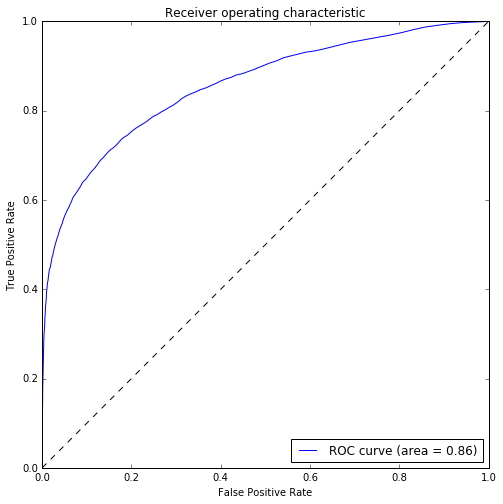

In [46]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Feature importances
The random forest model also allows us to see which features were important for modeling the data.

In [45]:
cols = X.columns
feature_scores = clf.feature_importances_

score_card = pd.DataFrame.from_items([('Features', cols),('Scores', feature_scores)])
score_card.sort_values(by = 'Scores', inplace=True, ascending=False)

print(score_card)

                   Features    Scores
14            feedbackScore  0.228142
17                    value  0.171039
18                  endHour  0.111669
6         buyItNowAvailable  0.078706
1           productId_value  0.072509
19               endWeekday  0.072454
15  positiveFeedbackPercent  0.048751
10             shippingType  0.035477
13       feedbackRatingStar  0.030446
3               conditionId  0.022414
2      conditionDisplayName  0.020226
9         expeditedShipping  0.019433
12          returnsAccepted  0.018643
16           topRatedSeller  0.016437
7          bestOfferEnabled  0.015384
5               listingType  0.011821
0            productId_type  0.011026
11           isShippingFree  0.009611
4                   country  0.003408
8             paymentMethod  0.002404


We see that the most important features have to do with the time of day that the listing started and ended and the day of month that the listing started and ended. These variables are may be highly correlated, so we should be careful not to read too much into the model at this point. We can say, however, that listing time features are predictive for the listing outcome.